In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# SHOT GUN APPROACH FOR **WHITE NOISE**
상호 독립이며, 무작위로 발생하는 randomness/불확실성을 알려주는 변수?
- **최대한의 feature engineering**
    - 일단 많이 만들고 나중에 좋은 변수만 선택 (feature selection, 차원축소, ...)
- minor features로부터 +@ 패턴 찾아보기
- 결측 여부(color, carrier, productline)
    - 시간이나 모델에 대한 어떤 정보를 주고 있을까?

In [137]:
df = pd.read_csv('./data/galaxy.csv')
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1


# 시간에 대한 정보 = index
- 데이터가 시간 순으로 수집되었다고 가정해보자.
    - 정확한 시간 간격 등은 표현하지 못하지만, **순서(order)에 대한 정보**를 가지고 있다
- 상관계수(pearson-r) > BuyItNow, sold와 -0.2에 가까운 상관성

<AxesSubplot:>

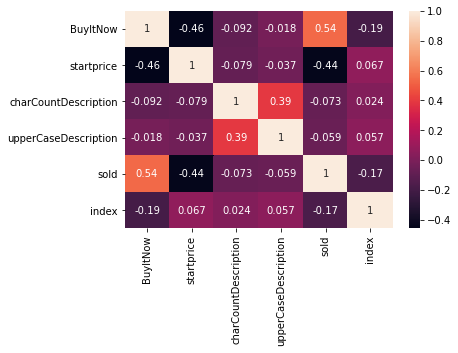

In [145]:
df['index'] = df.index
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:xlabel='index', ylabel='Count'>

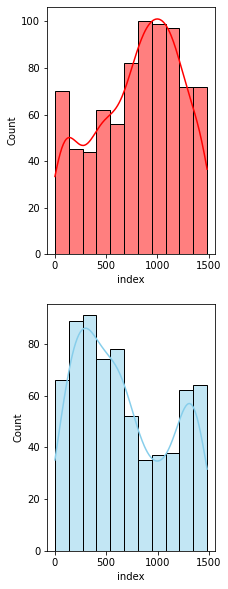

In [157]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3,10))
sns.histplot(df[df['sold']==0]['index'], ax=axes[0], color='red', kde=True)
sns.histplot(df[df['sold']==1]['index'], ax=axes[1], color='skyblue', kde=True)

<AxesSubplot:xlabel='index', ylabel='Count'>

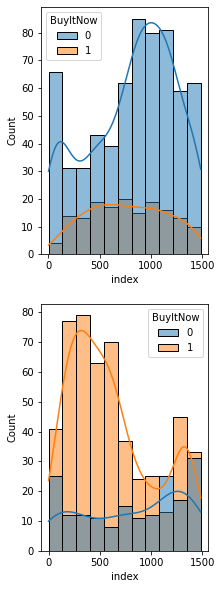

In [158]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3,10))
sns.histplot(x='index', data=df[df['sold']==0], hue='BuyItNow',ax=axes[0], color='red', kde=True)
sns.histplot(x='index', data=df[df['sold']==1], hue='BuyItNow', ax=axes[1], color='skyblue', kde=True)

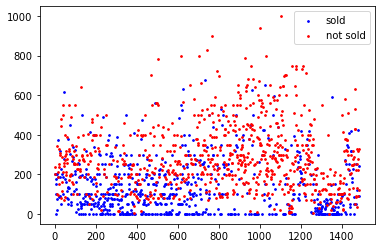

In [176]:
plt.scatter(df[df['sold']==1]['index'], df[df['sold']==1]['startprice'], s=3, c='b')
plt.scatter(df[df['sold']==0]['index'], df[df['sold']==0]['startprice'],
           c='red', s=3)
plt.legend(['sold', 'not sold'])

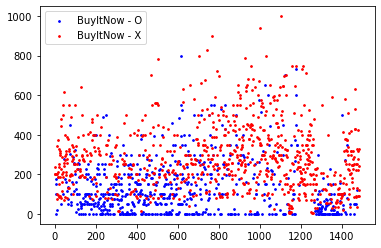

In [177]:
plt.scatter(df[df['BuyItNow']==1]['index'], df[df['BuyItNow']==1]['startprice'], s=3, c='b')
plt.scatter(df[df['BuyItNow']==0]['index'], df[df['BuyItNow']==0]['startprice'],
           c='red', s=3)
plt.legend(['BuyItNow - O', 'BuyItNow - X'])

In [178]:
df.groupby(['BuyItNow', 'sold'])['startprice'].mean()

BuyItNow  sold
0         0       301.563928
          1       240.149944
1         0       233.271937
          1        96.654596
Name: startprice, dtype: float64

In [179]:
df.groupby(['BuyItNow', 'sold'])['startprice'].std()

BuyItNow  sold
0         0       170.600174
          1       144.437882
1         0       154.668555
          1       110.902089
Name: startprice, dtype: float64

### `(BuyItNow=0, sold=1)` =? `(BuyItNow=1, sold=0)`
- `startprice` 만으로는 구별하기 힘들다

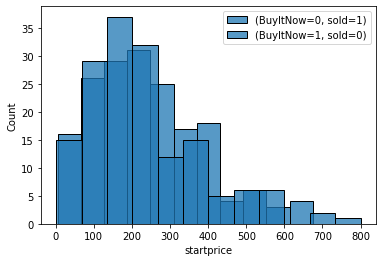

In [185]:
sns.histplot(df[(df['BuyItNow']==0) & (df['sold']==1)]['startprice'])
sns.histplot(df[(df['BuyItNow']==1) & (df['sold']==0)]['startprice'])
plt.legend(['(BuyItNow=0, sold=1)', '(BuyItNow=1, sold=0)'])

# groupby Major features

- 핵심 변수(BuyItNow, startprice, productline) 조건이 비슷할 때, 팔린 것 vs. 팔리지 않은 것 간의 차이를 설명해 줄 수 있는가?

In [140]:
BIN_unique_conditions = [df['BuyItNow']==unq for unq in df['BuyItNow'].unique()]
pd_unique_conditions = [df['productline']==unq for unq in df['productline'].unique()]
sold_unique_conditions = [df['sold']==unq for unq in df['sold'].unique()]

### (BuyItNow=0)일 때, model / sold 에 따른 startprice
- 안팔린 게 팔린 것보다 훨씬 많다
- 분포의 차이를 구분하기 힘들다

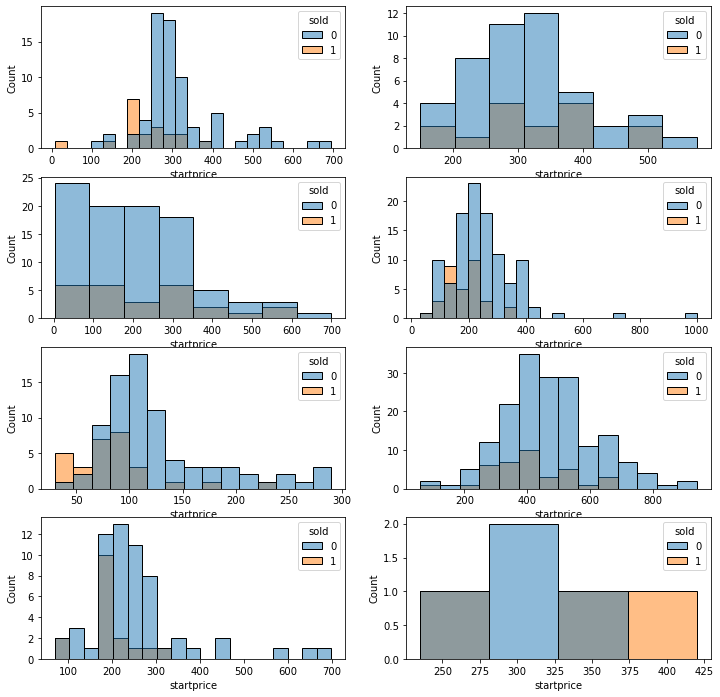

In [141]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
for i, pdcond in enumerate(pd_unique_conditions):
    r_idx = int(i/2)
    c_idx = int(i%8)%2
    #print(r_idx, c_idx)
    sns.histplot(x='startprice',
                 data=df[(df['BuyItNow']==0) & pdcond],
                 hue='sold',
                ax=axes[r_idx][c_idx])

#df_bin0_pd0 = df[BIN_unique_conditions[0] & pd_unique_conditions[0]]

### (BuyItNow=1)일 때, model / sold 에 따른 startprice
- 팔린 게 안팔린 것보다 훨씬 많다
- 분포의 차이가 상대적으로 뚜렷하다
    - 그럼에도 불구하고 상당부분이 중복된다

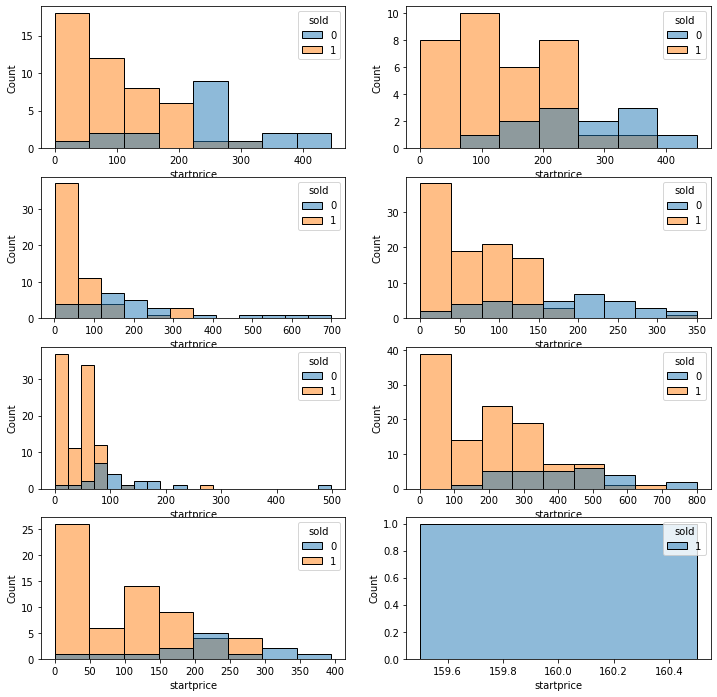

In [186]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
for i, pdcond in enumerate(pd_unique_conditions):
    r_idx = int(i/2)
    c_idx = int(i%8)%2
    #print(r_idx, c_idx)
    sns.histplot(x='startprice',
                 data=df[(df['BuyItNow']==1) & pdcond],
                 hue='sold',
                ax=axes[r_idx][c_idx])

#df_bin0_pd0 = df[BIN_unique_conditions[0] & pd_unique_conditions[0]]

# Randomness / Noise를 가능한 뚜렷하게, 구분 가능하게 해 보자
# 기본 방향성 > 최대한의 주변 정보를 살리고, 나중에 추려내자 (PCA 등)
- color
- carrier
- productline
- noDescription
- charCountDescription
- upperCaseDescription
- index

In [187]:
df.columns

Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
       'noDescription', 'charCountDescription', 'upperCaseDescription', 'sold',
       'index'],
      dtype='object')

# df.color
- 신뢰하기 어려운 정보 (공식 자료 등 확인 시, 불일치하는 데이터 많음)
- 색깔이 아니라, randomness에 초점을 맞춰보자
    - human error 측면에서는 매우 풍부한(?) randomness를 지님
        - 삼성 갤럭시는 space gray라는 색깔을 낸 적이 없음 (!)
        - 사람들은 Black 색상에 대해서만 시그니쳐 컬러 네임을 기억하여 사용했음
            - 셀러 입장에서 굳이 풀네임을 언급하는 게 갬성을 자극한다고 판단한 걸까?
        - 약 40%가 NaN값
            - 왜 이렇게 결측치가 많을까?
            - 핸드폰의 색상은 일반적으로 후면 커버의 색상을 의미
            - 부서졌거나 하여 부품용으로 파는 핸드폰?

In [197]:
df.color.unique()

array(['White', nan, 'Space Gray', 'Midnight Black', 'Aura Black', 'Gold',
       'Black', 'Prism Black'], dtype=object)

In [196]:
df.color.isna().sum()/len(df)

0.3993265993265993

### df.color - 결측 vs. 결측X

In [199]:
df['color_NaN'] = df['color'].apply(lambda x: 1 if type(x)!=str else 0)

In [202]:
# 색상이 기재된 핸드폰, 892개
df[df['color_NaN']==0]['productline'].value_counts()

Galaxy_Note10    232
Galaxy_S8        152
Galaxy_S7        135
Galaxy_Note8     105
Galaxy_S9         98
Unknown           88
Galaxy_Note9      74
Galaxy_S10         8
Name: productline, dtype: int64

In [208]:
df[df['color_NaN']==0]['startprice'].mean()

229.6214013452915

<AxesSubplot:xlabel='startprice', ylabel='Count'>

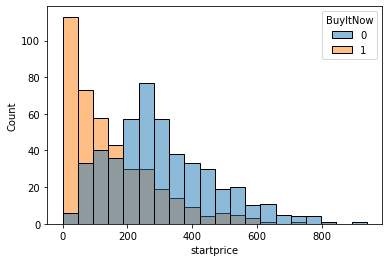

In [205]:
sns.histplot(x='startprice', data=df[df['color_NaN']==0], hue='BuyItNow')

In [203]:
# 색상이 기재되지 않은 핸드폰, 593개
df[df['color_NaN']==1]['productline'].value_counts()

Galaxy_S8        125
Galaxy_Note10    119
Unknown          116
Galaxy_S7         92
Galaxy_S9         60
Galaxy_Note8      48
Galaxy_Note9      33
Name: productline, dtype: int64

In [207]:
df[df['color_NaN']==1]['startprice'].mean()

197.62443507588532

<AxesSubplot:xlabel='startprice', ylabel='Count'>

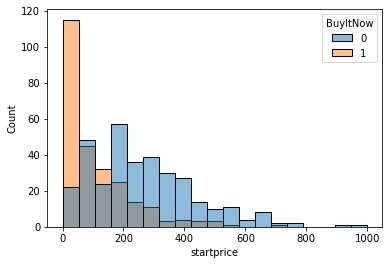

In [206]:
sns.histplot(x='startprice', data=df[df['color_NaN']==1], hue='BuyItNow')

### df.color - gamsung vs. no gamsung
40%를 차지하는 NaN이 모두 no gamsung으로 분류되는 건 좀 슬픔.
- gamsung
    - 474개
    - 50.6% 확률로 낙찰 성공
- no gamsung
    - 1011개
    - 44.1% 확률로 낙찰 성공

In [209]:
df.color.unique()

array(['White', nan, 'Space Gray', 'Midnight Black', 'Aura Black', 'Gold',
       'Black', 'Prism Black'], dtype=object)

In [210]:
df['color_sentiment'] = df['color'].apply(lambda x: 1 if x in ['Space Gray', 'Midnight Black',
                                      'Aura Black', 'Prism Black'] else 0)

In [211]:
df.groupby('color_sentiment')['startprice'].mean()

color_sentiment
0    223.489050
1    202.671203
Name: startprice, dtype: float64

In [215]:
len(df[df['color_sentiment']==1]), len(df[df['color_sentiment']==0])

(474, 1011)

In [216]:
df.groupby('color_sentiment')['sold'].mean()

color_sentiment
0    0.441147
1    0.506329
Name: sold, dtype: float64

In [217]:
df.groupby('color_sentiment')['BuyItNow'].mean()

color_sentiment
0    0.430267
1    0.489451
Name: BuyItNow, dtype: float64

### 갬성 색상 / 갬성 색상 아님 / NaN
- 미지의 갬성까지 정보를 살려보자
- NaN vs. Non-NaN 컬럼의 상위호환?

In [218]:
# NaN을 다시 따로 분류하면?
df['color_sentiment2'] = df['color'].apply(lambda x: 1 if x in ['Space Gray', 'Midnight Black',
                                      'Aura Black', 'Prism Black']
                                          else 0 if type(x) == str
                                         else -1)

In [221]:
df.color_sentiment2.value_counts()

-1    593
 1    474
 0    418
Name: color_sentiment2, dtype: int64

In [219]:
df.groupby('color_sentiment2')['sold'].mean()

color_sentiment2
-1    0.453626
 0    0.423445
 1    0.506329
Name: sold, dtype: float64

In [220]:
df.groupby('color_sentiment2')['BuyItNow'].mean()

color_sentiment2
-1    0.433390
 0    0.425837
 1    0.489451
Name: BuyItNow, dtype: float64

### Power China, Gold Premium?
- 그다지

In [222]:
df.groupby('color')['startprice'].mean().sort_values(ascending=False)

color
Gold              443.593846
Aura Black        319.457368
Prism Black       299.000000
Space Gray        276.767389
White             242.726768
Black             159.865263
Midnight Black    145.545000
Name: startprice, dtype: float64

In [224]:
df.groupby('color')['sold'].mean().sort_values(ascending=False)

color
Midnight Black    0.558394
Space Gray        0.450000
White             0.435976
Black             0.421053
Gold              0.346154
Aura Black        0.315789
Prism Black       0.000000
Name: sold, dtype: float64

In [226]:
df[df['color']=='Gold']['productline'].value_counts()

Galaxy_Note10    46
Unknown           4
Galaxy_Note8      1
Galaxy_S10        1
Name: productline, dtype: int64

<AxesSubplot:>

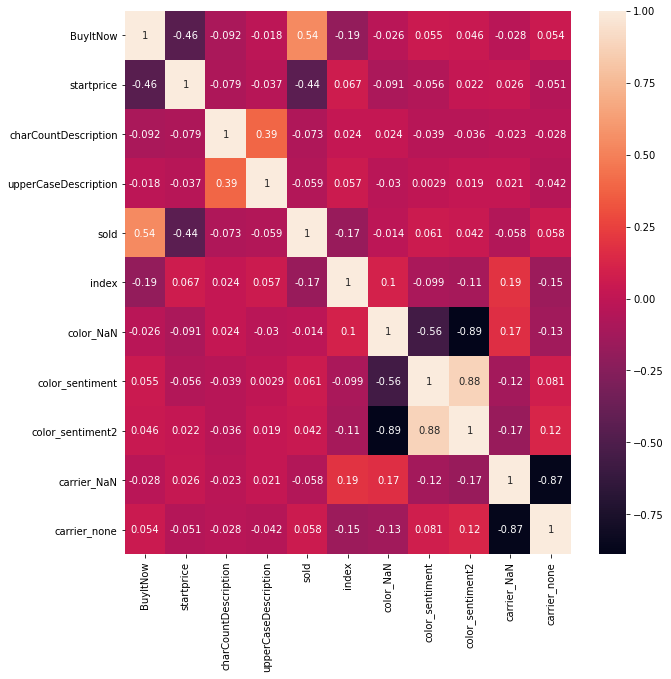

In [237]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

# df.carrier

In [8]:
df['carrier'].unique()

array(['None', nan, 'AT&T', 'Sprint/T-Mobile', 'Verizon'], dtype=object)

In [228]:
df['carrier_NaN'] = df['carrier'].apply(lambda x: 1 if type(x) != str else 0)
df['carrier_none'] = df['carrier'].apply(lambda x: 1 if x=='None' else -1 if type(x) != str else 0)

In [229]:
df.groupby('carrier_NaN')['startprice'].mean()

carrier_NaN
0    214.534512
1    225.743105
Name: startprice, dtype: float64

In [230]:
df.groupby('carrier_none')['startprice'].mean()

carrier_none
-1    225.743105
 0    232.693576
 1    207.885307
Name: startprice, dtype: float64

<AxesSubplot:xlabel='startprice', ylabel='Count'>

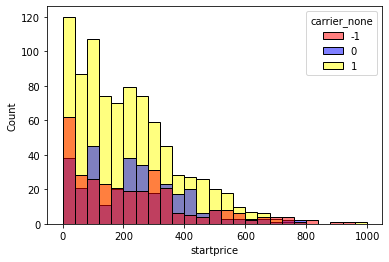

In [232]:
sns.histplot(x='startprice', data=df, hue='carrier_none', palette={-1:'red',
                                                                  0:'blue',
                                                                  1:'yellow'})

<AxesSubplot:xlabel='startprice', ylabel='Count'>

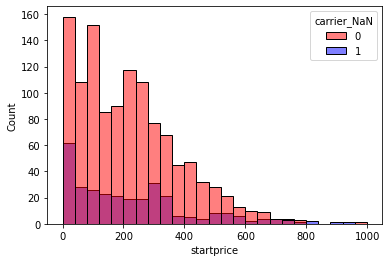

In [236]:
sns.histplot(x='startprice', data=df, hue='carrier_NaN', palette={0:'red',
                                                                  1:'blue'})

<AxesSubplot:>

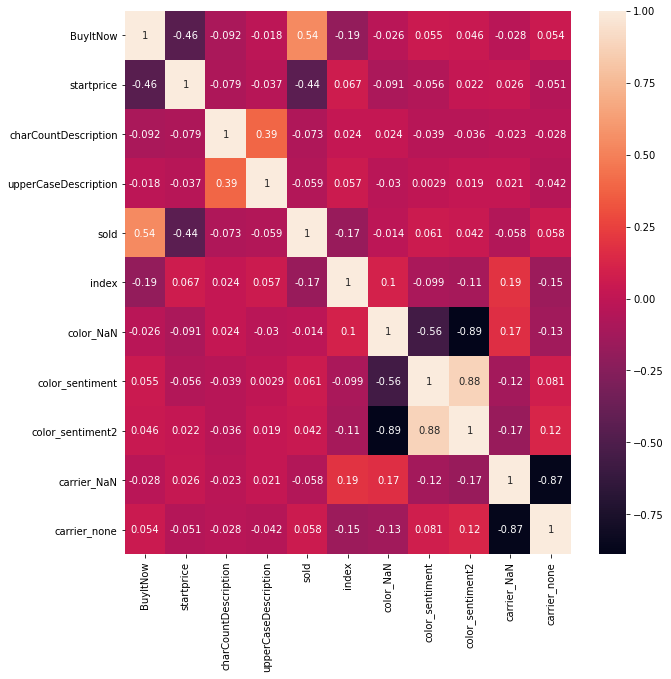

In [238]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

# df.productline
- **중복된 정보를 가진 컬럼**
    - 경매시점이 아닌 제품 출시 순서에 대한 정보(시간) + Note 여부 정보(모델)
    - 시간정보(ordinal)와 모델정보(binary) 두 칼럼으로 구분하기
- 'Unknown'
    1. 최대한 비슷한 카테고리 값으로 impute
    2. 그대로 사용하기

In [239]:
df.productline.unique()

array(['Galaxy_S9', 'Galaxy_Note9', 'Unknown', 'Galaxy_S8', 'Galaxy_S7',
       'Galaxy_Note10', 'Galaxy_Note8', 'Galaxy_S10'], dtype=object)

In [ ]:
# 시간정보(SeriesNumber)와 모델정보(Note)를 두 개의 컬럼으로 구분하기
df['productline'].apply(lambda x: )

In [ ]:
# Unknown

# df.noDescription

In [42]:
df['noDescription'].unique()

array(['contains description', 'no description'], dtype=object)

In [43]:
df['hasDescription'] = df['noDescription'].apply(lambda x: 1 if x=='contains description' else 0)

In [52]:
df.groupby('hasDescription')['sold'].mean()

hasDescription
0    0.434022
1    0.482477
Name: sold, dtype: float64

In [53]:
df.groupby('hasDescription')['BuyItNow'].mean()

hasDescription
0    0.408585
1    0.478972
Name: BuyItNow, dtype: float64

In [54]:
df.groupby('hasDescription')['startprice'].mean()

hasDescription
0    195.555167
1    232.487593
Name: startprice, dtype: float64

In [82]:
df.groupby('hasDescription')['productline'].value_counts()

hasDescription  productline  
0               Galaxy_Note10    131
                Galaxy_S7        104
                Galaxy_S8        104
                Unknown           85
                Galaxy_S9         84
                Galaxy_Note8      82
                Galaxy_Note9      37
                Galaxy_S10         2
1               Galaxy_Note10    220
                Galaxy_S8        173
                Galaxy_S7        123
                Unknown          119
                Galaxy_S9         74
                Galaxy_Note8      71
                Galaxy_Note9      70
                Galaxy_S10         6
Name: productline, dtype: int64

# df.charCountDescription

In [44]:
df[['charCountDescription', 'upperCaseDescription']]

,charCountDescription,upperCaseDescription
0,0,0
1,0,0
2,100,2
3,0,0
4,0,0
...,...,...
1480,96,2
1481,97,5
1482,93,1
1483,92,2


<AxesSubplot:xlabel='charCountDescription', ylabel='Count'>

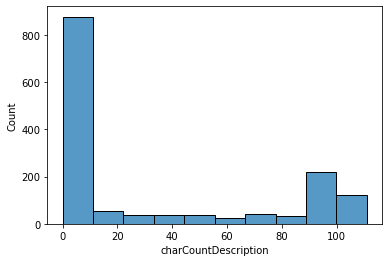

In [65]:
sns.histplot(df['charCountDescription'], bins=10)

In [69]:
df['charCountDescriptionBins'] = df['charCountDescription'].apply(lambda x: 0 if x==0
                                                                    else 1 if (x<90)
                                                                    else 2)

In [71]:
df.groupby('charCountDescriptionBins')['sold'].mean()

charCountDescriptionBins
0    0.482477
1    0.488136
2    0.386228
Name: sold, dtype: float64

In [72]:
df.groupby('charCountDescriptionBins')['BuyItNow'].mean()

charCountDescriptionBins
0    0.478972
1    0.477966
2    0.347305
Name: BuyItNow, dtype: float64

<AxesSubplot:xlabel='startprice', ylabel='Count'>

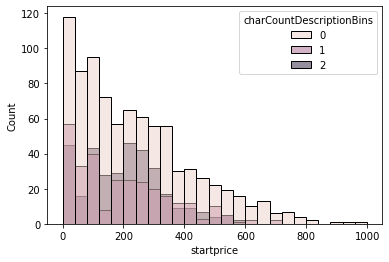

In [79]:
sns.histplot(x='startprice', data=df, hue='charCountDescriptionBins')

In [83]:
df.groupby('charCountDescriptionBins')['productline'].value_counts()

charCountDescriptionBins  productline  
0                         Galaxy_Note10    220
                          Galaxy_S8        173
                          Galaxy_S7        123
                          Unknown          119
                          Galaxy_S9         74
                          Galaxy_Note8      71
                          Galaxy_Note9      70
                          Galaxy_S10         6
1                         Galaxy_Note10     69
                          Galaxy_S8         53
                          Galaxy_S7         50
                          Unknown           40
                          Galaxy_Note8      33
                          Galaxy_S9         32
                          Galaxy_Note9      17
                          Galaxy_S10         1
2                         Galaxy_Note10     62
                          Galaxy_S7         54
                          Galaxy_S9         52
                          Galaxy_S8         51
                    

<AxesSubplot:xlabel='upperCaseDescription', ylabel='Count'>

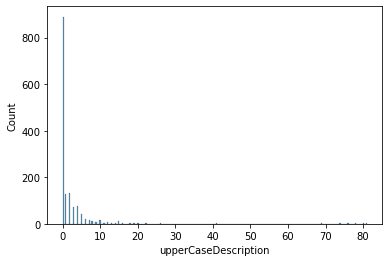

In [49]:
sns.histplot(df['upperCaseDescription'])

In [ ]:
# BuyItNow, productline이 동일하지만 sold가 다른 example
bin0 = df['BuyItNow']==0
bin1 = df['BuyItNow']==1

